# Building a Classification Model to Predict Survival

## // Importing necessary libraries //

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline
sns.set_style('darkgrid')

## // Reading in the data //

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('gender_submission.csv')

## // Cleaning the data and EDA //

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


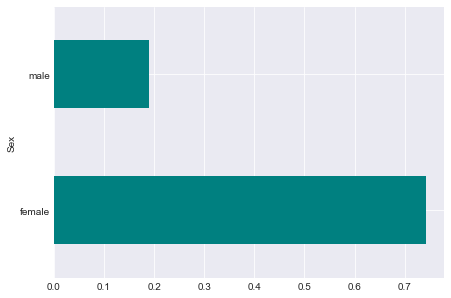

In [5]:
# Let's do some brief visual explorations to see if anything jumps out at us.
train.groupby('Sex')['Survived'].mean().plot(figsize=(7,5), kind='barh', grid=True, color='Teal');

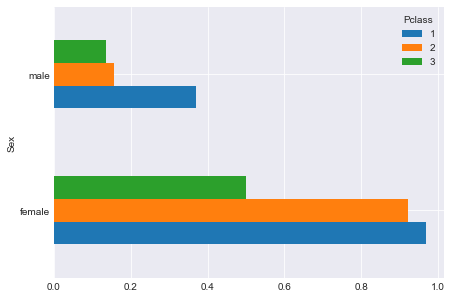

In [151]:
# And one more for good measure:
train.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack().plot(figsize=(7,5), kind='barh');

In [152]:
train.shape

(891, 12)

### Checking for nulls and strategy

In [153]:
# Checking for null values

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [154]:
# Going to drop those Embarked rows since they won't affect outcome too much.

train.dropna(subset=['Embarked'], how='any', inplace=True)

In [155]:
# Going to drop the cabin column as well. There are too many missing to make dependable predictions.

train.drop('Cabin', axis=1, inplace=True)

In [156]:
# What to do about those missing 'Age' values? I think I'll impute them with the mean for now.

train.Age.fillna(train.Age.mean(), inplace=True)

### Some small feature manipulations

In [157]:
# Encoding the 'Sex' column so we can feed it into a model.

sex_encoded = {
    'male': 1,
    'female': 0
}

train['Sex'] = train.Sex.map(sex_encoded)

In [158]:
# Let's take a look at the rest of the dtypes and see what we want to use

train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [159]:
# So I think out of those, the only object one that seems useful is maybe Embarked?
# Let's go ahead and make dummy variables of those

train['Embarked'] = train['Embarked'].astype('category')
train = pd.get_dummies(train, columns = ['Embarked'], drop_first = True)

In [160]:
# And then for the last one I'll go ahead and make a combined "Family_Count" by summing "SibSp" and "Parch"

train['Family_Count'] = train.SibSp + train.Parch

### Going to do the same cleaning and everything to the test set

In [161]:
test.shape

(418, 11)

In [162]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [165]:
test.Fare.fillna(test.Fare.median(), inplace= True)

In [166]:
test.Age.fillna(test.Age.mean(), inplace=True)

In [167]:
test.drop('Cabin', axis=1, inplace=True)

In [168]:
test['Sex'] = test.Sex.map(sex_encoded)

In [169]:
test['Embarked'] = test['Embarked'].astype('category')
test = pd.get_dummies(test, columns = ['Embarked'], drop_first = True)

In [170]:
test['Family_Count'] = test.SibSp + test.Parch

## // Setting up and running the models //

In [171]:
# Selecting our features and our target variable

features = [col for col in train.columns if col not in ['Survived', 'PassengerId', 'Name', 'Ticket']]
X = train[features]
y = train['Survived']

In [172]:
# Looking to see what our baseline is, in this case the majority class is about 62%

train.Survived.value_counts(normalize=True)

0    0.617548
1    0.382452
Name: Survived, dtype: float64

In [173]:
# Setting up train, test, split. Setting random_state for reproducibility

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, stratify = y, random_state=44)

In [174]:
from sklearn.metrics import accuracy_score

In [175]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [176]:
# Let's look at a DecisionTree and optimize it

dtc = DecisionTreeClassifier(random_state = 44)
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50],
    'criterion':['gini', 'entropy']
}
gs_dtc = GridSearchCV(dtc, dtc_params)
gs_dtc.fit(X_train, y_train)

print(gs_dtc.best_score_)
print(gs_dtc.best_params_)
print(gs_dtc.score(X_holdout, y_holdout))

0.8393393393393394
{'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_split': 2}
0.7847533632286996


In [177]:
dt_opti = gs_dtc.best_estimator_

In [178]:
# Let's look at a RandomForest and optimize it

rf = RandomForestClassifier(random_state=44)

rf_params = {
    'n_estimators': [5, 10, 15, 20, 25],
    'max_depth': [None, 1,2,3],
    'max_features': ['auto', 'log2']
}
gs_rf = GridSearchCV(rf, rf_params)
gs_rf.fit(X_train, y_train)

print (gs_rf.best_score_)
print (gs_rf.best_params_)
print (gs_rf.score(X_holdout, y_holdout))

0.8168168168168168
{'max_depth': 2, 'max_features': 'auto', 'n_estimators': 5}
0.757847533632287


In [179]:
rf_opti = gs_rf.best_estimator_

In [180]:
# Let's look at an ExtraTrees and optimize it with Gridsearch

extr = ExtraTreesClassifier(random_state=44)

extr_params = {
    'n_estimators': [5, 10, 15, 20, 25],
    'max_depth': [None, 1,2,3],
    'max_features': ['auto', 'log2']
}
gs_extr = GridSearchCV(extr, extr_params)
gs_extr.fit(X_train, y_train)

print (gs_extr.best_score_)
print(gs_extr.best_params_)
print(gs_extr.score(X_holdout, y_holdout))

0.8243243243243243
{'max_depth': 2, 'max_features': 'auto', 'n_estimators': 10}
0.7757847533632287


In [181]:
ext_opti = gs_extr.best_estimator_

In [182]:
# Let's look at an AdaBoost Classifier and optimize it with GridSearch

ada_clf = AdaBoostClassifier(random_state=42)

ada_params = {
#     'DecisionTreeClassifier__max_depth': [None, 1,2,3,4,5],
    'n_estimators': [5, 10, 15, 20, 25],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [.5, .75, 1.0]
}
gs_ada = GridSearchCV(ada_clf, ada_params)
gs_ada.fit(X_train, y_train)

print (gs_ada.best_score_)
print(gs_ada.best_params_)
print(gs_ada.score(X_holdout, y_holdout))

0.8288288288288288
{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 10}
0.7892376681614349


In [183]:
ada_opti = gs_ada.best_estimator_

In [184]:
# Now let's take all those models together and ensemble them for (hopefully) the best results

voting_clf = VotingClassifier(estimators=[('rf', rf_opti), ('extr', ext_opti), ('dtc', dt_opti), ('ada_clf', ada_opti)],
                              voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh...rithm='SAMME', base_estimator=None, learning_rate=1.0,
          n_estimators=10, random_state=42))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [185]:
voting_clf.score(X_holdout, y_holdout)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7847533632286996

In [186]:
# So far it looks like the AdaBoost model performed best on the holdout set, so let's score that on the test data

X_test = test[features]

In [187]:
predictions = ada_opti.predict(X_test)

In [188]:
# Now let's add those to the test data set and prepare it for submission

test['Survived'] = predictions

test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S,Family_Count,Survived
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,1,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,1,1,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,1,0,0,0


In [189]:
sample.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [190]:
test.shape

(418, 13)

In [191]:
test[['PassengerId', 'Survived']].to_csv('titanic_submission.csv', index=False)

In [192]:
submissions = pd.read_csv('titanic_submission.csv')
submissions.shape

(418, 2)